In [9]:
# Read in the data file. 
# Data found from this paper: https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-7-122#Sec13
# Will read in the protein interaction network with the distances being the confidence score of an interaction

import numpy as np
# Read in the file

# try:
#     with open('interaction.txt', 'r') as file:
#         content = file.read()
#         print(content)
# except FileNotFoundError:
#     print("Error: The file 'your_file.txt' was not found.")

file_path = 'interaction.txt'
# Put the first, second, and sixth columns into arrays
protein_interaction = np.loadtxt(file_path, delimiter='\t', usecols=(0,1),dtype=str)
conf_score = np.loadtxt(file_path, delimiter='\t', usecols=(5))

unique_nodes,first_occurence = np.unique(protein_interaction[:,0],return_index=True)

# Find unique differences
#test = np.setdiff1d(protein_interaction[:,1],protein_interaction[:,0])

# Doing this so I can make a matrix
unique_proteins_total = np.concatenate((protein_interaction[:,0],protein_interaction[:,1]))
unique_nodes2 = np.unique(unique_proteins_total)

# Next make it into a matrix
network_matrix = np.zeros((unique_nodes2.size,unique_nodes2.size))

# Loop through all of the unique strings and add 1s to the matrix
counter = 0
for proteins in unique_nodes2:
    # See where the proteins are
    indices = np.where(protein_interaction[:,0] == proteins)
    indices = np.array(indices)
    if indices.size == 0:
        indices = np.where(protein_interaction[:,1] == proteins)
        for p in indices[0]:
            interaction = np.where(unique_nodes2 == protein_interaction[p,0])
            network_matrix[counter,interaction] = 1
            network_matrix[interaction,counter] = 1
    else:
        for p in indices[0]:
            interaction = np.where(unique_nodes2 == protein_interaction[p,1])
            network_matrix[counter,interaction] = 1
            network_matrix[interaction,counter] = 1
    counter = counter + 1
        
print(network_matrix)    

                           

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


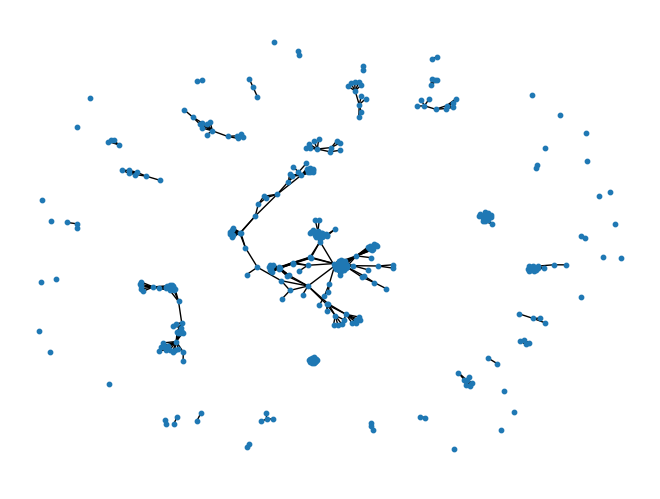

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Plot the matrix as a graph
np.fill_diagonal(network_matrix,0)
G = nx.from_numpy_array(network_matrix)
#G.remove_edges_from(nx.selfloop_edges(G))
nx.draw(G,node_size=10,pos=nx.fruchterman_reingold_layout(G))
plt.show()

In [49]:
# Make a function that will do the Dijkstra's algorithm
def dijkstras(adjacency_matrix,labels,start,end):
    start_index = np.where(labels == start)
    end_index  = np.where(labels == end)
    start_index = np.array(start_index)
    end_index = np.array(end_index)
    if start_index.size == 0 or end_index.size == 0:
        raise ValueError("One of the nodes is not within the labels")

    # Mark all nodes as unvisited
    visit_vector = np.zeros((labels.size,1))

    # Make an array that will hold distances and previous node of shortest path
    confidence_vector = np.zeros((labels.size,1))
    previous_node_vector = np.full(labels.size, np.inf) 
    #previous_node_vector = previous_node_vector.T

    counter = 1
    while counter > 0:#np.all(visit_vector != 1):
        if counter == 1:
            counter = counter + 1
            current_node = start_index[0]
        # Iterate through and find the nodes and update confidence and previous_node_vector
        for i in range(labels.size):
            if adjacency_matrix[current_node,i] > 0 and abs(adjacency_matrix[current_node,i]-confidence_vector[i]) > confidence_vector[i]:
                #confidence_vector[i] = adjacency_matrix[current_node,i]+confidence_vector[i]
                confidence_vector[i] = abs(adjacency_matrix[current_node,i]-confidence_vector[i])
                previous_node_vector[i] = current_node

        # Find the node that has the highest confidence and is unvisited
        visit_vector[current_node] = 1
        next_index = 0
        next_index_max = 0
        for i in range(labels.size):
            if confidence_vector[i] > next_index_max and visit_vector[i] == 0:
                next_index_max = confidence_vector[i]
                next_index = i

        if next_index == current_node:
            break
        else:
            current_node = next_index
    if np.isinf(previous_node_vector[end_index[0]]):
        raise ValueError("The start and end node is not connected")

    path = np.array(labels[end_index[0]])
    path_idx = end_index[0]
    while path_idx != start_index[0]:
        path = np.insert(path,0,labels[int(previous_node_vector[path_idx])])
        path_idx = int(previous_node_vector[path_idx])
        # test = np.where(path == labels[int(previous_node_vector[path_idx])])
        # test = np.array(test)
        # if  test.size > 0:
        #     break
        

    #path = np.insert(path,0,labels[start_index[0]])
    return path
        
    

In [45]:
file_path = 'interaction.txt'
# Put the first, second, and sixth columns into arrays
protein_interaction = np.loadtxt(file_path, delimiter='\t', usecols=(0,1),dtype=str)
conf_score = np.loadtxt(file_path, delimiter='\t', usecols=(5))

unique_nodes,first_occurence = np.unique(protein_interaction[:,0],return_index=True)

# Find unique differences
#test = np.setdiff1d(protein_interaction[:,1],protein_interaction[:,0])

# Doing this so I can make a matrix
unique_proteins_total = np.concatenate((protein_interaction[:,0],protein_interaction[:,1]))
unique_nodes2 = np.unique(unique_proteins_total) 
print(unique_nodes2)

# Next make it into a matrix
network_matrix = np.zeros((unique_nodes2.size,unique_nodes2.size))

# Loop through all of the unique strings and add 1s to the matrix
counter = 0
for proteins in unique_nodes2:
    # See where the proteins are
    indices = np.where(protein_interaction[:,0] == proteins)
    indices = np.array(indices)
    if indices.size == 0:
        indices = np.where(protein_interaction[:,1] == proteins)
        for p in indices[0]:
            interaction = np.where(unique_nodes2 == protein_interaction[p,0])
            network_matrix[counter,interaction] = conf_score[p]
            network_matrix[interaction,counter] = conf_score[p]
    else:
        for p in indices[0]:
            interaction = np.where(unique_nodes2 == protein_interaction[p,1])
            network_matrix[counter,interaction] = conf_score[p]
            network_matrix[interaction,counter] = conf_score[p]
    counter = counter + 1
np.fill_diagonal(network_matrix,0)

['MAL13P1.120' 'MAL13P1.135' 'MAL13P1.148' 'MAL13P1.167' 'MAL13P1.169'
 'MAL13P1.196' 'MAL13P1.216' 'MAL13P1.253' 'MAL13P1.262' 'MAL13P1.270'
 'MAL13P1.271' 'MAL13P1.283' 'MAL13P1.324' 'MAL13P1.327' 'MAL13P1.338'
 'MAL13P1.35' 'MAL13P1.47' 'MAL13P1.68' 'MAL13P1.76' 'MAL13P1.92'
 'MAL13P1.95' 'MAL7P1.150' 'MAL7P1.155' 'MAL7P1.158' 'MAL7P1.164'
 'MAL7P1.93' 'MAL8P1.121' 'MAL8P1.128' 'MAL8P1.131' 'MAL8P1.142'
 'MAL8P1.48' 'MAL8P1.72' 'MAL8P1.9' 'PF07_0046' 'PF07_0054' 'PF07_0065'
 'PF07_0068' 'PF07_0077' 'PF07_0078' 'PF07_0088' 'PF07_0100' 'PF07_0112'
 'PF07_0115' 'PF08_0009' 'PF08_0031' 'PF08_0038' 'PF08_0039' 'PF08_0049'
 'PF08_0055' 'PF08_0063' 'PF08_0066' 'PF08_0067' 'PF08_0075' 'PF08_0076'
 'PF08_0078' 'PF08_0084' 'PF10_0038' 'PF10_0046' 'PF10_0058' 'PF10_0062'
 'PF10_0072' 'PF10_0079' 'PF10_0081' 'PF10_0103' 'PF10_0111' 'PF10_0114'
 'PF10_0117' 'PF10_0121' 'PF10_0136' 'PF10_0143' 'PF10_0153' 'PF10_0169'
 'PF10_0177' 'PF10_0217' 'PF10_0218' 'PF10_0232' 'PF10_0264' 'PF10_0271'
 'PF10_

In [51]:
path = dijkstras(network_matrix,unique_nodes2,'PFE0160c','PFE1020w')
print(path)
path = dijkstras(network_matrix,unique_nodes2,'PF11_0255','PF10_0079')
print(path)

['PFE0160c' 'PF08_0084' 'PFE1020w']
['PF11_0255' 'MAL13P1.35' 'PF10_0079']
